In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from torch.utils import tensorboard

In [2]:
!wget https://raw.githubusercontent.com/chelvanai/LSTM_Forecast/main/airline-passengers.csv

--2022-09-08 04:57:09--  https://raw.githubusercontent.com/chelvanai/LSTM_Forecast/main/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2022-09-08 04:57:09 (45.9 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



In [4]:
df = pd.read_csv('airline-passengers.csv')

In [5]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
values = df.Passengers.values[:-4]

In [7]:
training_set = np.array(values)
training_set = np.expand_dims(training_set, axis=1)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)


def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)


num_epochs = 2500
learning_rate = 0.01

input_size = 1
hidden_size = 100
num_layers = 1

num_classes = 1
seq_length = 12

torch.manual_seed(0)

tb = tensorboard.SummaryWriter()


class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out


def train(training_data):
    x, y = sliding_windows(training_data, seq_length)

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    best_valid_loss = 2

    lstm = LSTM(input_size, hidden_size, num_classes, num_layers)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    tb.add_graph(lstm, dataX)

    lstm.train()

    # Train the model
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = lstm(dataX)
        loss = criterion(outputs, dataY)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch ", epoch)
            print("Loss ", loss.item())

            if loss.item() < best_valid_loss:
                best_valid_loss = loss.item()
                print("Weight saves!")
                torch.save(lstm.state_dict(), 'weight.pth')


train(training_data)


Epoch  0
Loss  0.16002154350280762
Weight saves!
Epoch  100
Loss  0.0052824863232672215
Weight saves!
Epoch  200
Loss  0.002034657634794712
Weight saves!
Epoch  300
Loss  0.0022457479499280453
Epoch  400
Loss  0.0015206999378278852
Weight saves!
Epoch  500
Loss  0.0009378831018693745
Weight saves!
Epoch  600
Loss  0.0007662168354727328
Weight saves!
Epoch  700
Loss  0.0006063918117433786
Weight saves!
Epoch  800
Loss  0.0005461835535243154
Weight saves!
Epoch  900
Loss  0.001499646226875484
Epoch  1000
Loss  0.00047196217929013073
Weight saves!
Epoch  1100
Loss  0.000417865056078881
Weight saves!
Epoch  1200
Loss  0.0004237584362272173
Epoch  1300
Loss  0.0008131432696245611
Epoch  1400
Loss  0.00026075728237628937
Weight saves!
Epoch  1500
Loss  0.00023252777464222163
Weight saves!
Epoch  1600
Loss  0.00016637504450045526
Weight saves!
Epoch  1700
Loss  0.00013810502423439175
Weight saves!
Epoch  1800
Loss  7.931375148473307e-05
Weight saves!
Epoch  1900
Loss  5.4528776672668755e-05
W

In [24]:
model = LSTM(input_size, hidden_size, num_classes, num_layers)
model.load_state_dict(torch.load('weight.pth'))
model.eval()

with torch.no_grad():
    n_days = 5
    res = []
    data = training_data.tolist()

    for i in range(1, n_days):
        test = torch.Tensor(np.array(data[-seq_length:]))

        predict = model(test.unsqueeze(0)).data.numpy()
        res.append(predict.item())

        data.append(predict.tolist()[0])

result = np.array(res)
final = sc.inverse_transform(np.expand_dims(result, axis=1))
output = np.squeeze(final, axis=1).tolist()

print(output)

[516.2699874639511, 477.25246477127075, 461.2660241127014, 469.28527224063873]


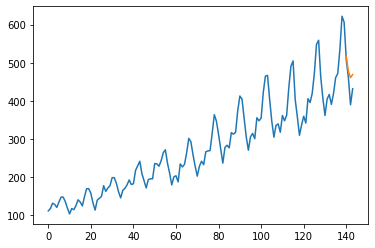

In [25]:
plt.plot(df.Passengers.values)
plt.plot(np.arange(len(values), len(values) + 4), output)
plt.show()

In [18]:
before = np.empty(len(df[:-4]))
before[:] = np.nan
pred_result = np.concatenate((before, np.array(output)), axis=0)
result = pd.Series(pred_result, name="Predicted")
result = result.apply(lambda x: round(x, 2))

In [19]:
df['Predicted'] = result.to_list()
df['difference'] = round(df['Passengers'] - df['Predicted'], 2)
df['error-percentage'] = (df['difference'] / df['Passengers']) * 100
df['error-percentage'] = df['error-percentage'].apply(lambda x: round(x, 2))

In [20]:
df.tail(10)

,Month,Passengers,Predicted,difference,error-percentage
134,1960-03,419,NaN,NaN,NaN
135,1960-04,461,NaN,NaN,NaN
136,1960-05,472,NaN,NaN,NaN
137,1960-06,535,NaN,NaN,NaN
138,1960-07,622,NaN,NaN,NaN
139,1960-08,606,NaN,NaN,NaN
140,1960-09,508,516.27,-8.27,-1.63
141,1960-10,461,477.25,-16.25,-3.52
142,1960-11,390,461.27,-71.27,-18.27
143,1960-12,432,469.29,-37.29,-8.63
